### Finetuning BERT base on IMDb Dataset  
The preprocessing functions defined in the `Increasing Size of IMDb Dataset.ipynb` jupyter notebook were used.


In [1]:
import torch
import numpy as np
import pandas as pd 
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers import AutoTokenizer, BertConfig
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from datasets import load_dataset, load_metric 
import datasets
import random
import matplotlib.pyplot as plt
import evaluate
import json


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

2022-11-10 21:05:54.161447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 21:05:54.257328: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 21:05:54.625070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/weiming/miniconda3/envs/weiming/lib/
2022-11-10 21:05:54.625114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer

cuda:0


In [2]:
# Maximum sequence length that the transformer model will take in. Can range from 0-512. 
# Higher sequence length means the model will "look" at more words which results in better classification. 

def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    pd.set_option('display.max_colwidth', None)
    return df

### Creating a Customer Trainer which overwrites the logging method to log training accuracy 
### after every epoch so that we can plot the training accuracy vs validation accuracy curve
class CustomTrainer(Trainer):
    def _maybe_log_save_evaluate(self, tr_loss, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log:

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss
            
            
            logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["accuracy"] = self.predict(test_dataset=self.train_dataset, metric_key_prefix="train").metrics['train_accuracy']
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
            self._report_to_hp_search(trial, epoch, metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)

### Function to extract training history from json file           
def get_history(filename):
    num_epochs_trained = 0
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    f = open(filename, "r")
    history = json.load(f)['log_history']
    
    for i in range(0, len(history), 2):
        num_epochs_trained += 1
        # Train 
        train_loss_list.append(history[i]['loss'])
        train_acc_list.append(history[i]['accuracy'])
        
        # Validation
        val_loss_list.append(history[i + 1]['eval_loss'])
        val_acc_list.append(history[i + 1]['eval_accuracy'])
    
    return num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list

### Removing <br /><br /> from the dataset
def preprocess_function_1(examples):
    for i in range(len(examples['text'])):
        examples['text'][i] = examples['text'][i].replace('<br /><br />', " ")
    return examples

### Tokenizing words into integer for embedding layer in BERT
def preprocess_function_2(examples):
    return tokenizer(examples['text'],max_length=seq_len, padding = "max_length",truncation=True)

### dataset must be converted to pd dataframe first
def chunk_half_fullstop_examples(dataset):
    for index, row in dataset.iterrows():
        sentence = row["text"][:]
        half_sentence_index = int(len(sentence) * 0.5);
        full_stop_index = sentence.find(".", half_sentence_index, len(sentence))
        if len(sentence.split(" ")) < 128 or full_stop_index == -1:
            continue
        else:
            first_half = sentence[: full_stop_index + 1] #including the fullstop
            second_half = sentence[full_stop_index + 1:]

            # Don't do anything if word is less than 128
            if len(first_half.split(" ")) < 128:
                continue
            else:
                # Consider it as another example if the second half number of words > 50?
                if len(second_half.split(" ")) > 50:
                    # Truncate the sample to the first half only if we are generating an additional example from the second half
                    dataset.at[index, "text"] = first_half[:]
                    # Add second half to dataset with the same label
                    pd_series = pd.Series({'text': second_half, 'label': row["label"]})
                    dataset = pd.concat([dataset, pd_series.to_frame().T], ignore_index=True)
    return dataset

In [3]:
dataset = load_dataset("imdb")
dataset = dataset.map(preprocess_function_1, batched = True)

dataset_train_original = dataset['train']
dataset_val = dataset['test']

print("----------Before Increasing Training Dataset----------")
print(f"# of Train Sequences: {len(dataset_train_original)},\
        # of Validation Sequences: {len(dataset_val)}")

# convert dataset_train to dataframe to increase train dataset size
dataset_train_class_labels = dataset_train_original.features.copy()
dataset_train = pd.DataFrame(dataset_train_original)

dataset_train = chunk_half_fullstop_examples(dataset_train)
dataset_train = chunk_half_fullstop_examples(dataset_train)
# convert dataset_train back to Dataset for training
dataset_train = datasets.Dataset.from_pandas(dataset_train)
dataset_train = dataset_train.cast(dataset_train_class_labels)

print("----------After Increasing Training Dataset----------")
print(f"# of Train Sequences: {len(dataset_train)},\
        # of Validation Sequences: {len(dataset_val)}")

Found cached dataset imdb (/home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-e4690b70d02f7f41.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-8e22d6e5fe5f4292.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-2dfef9f5282119ba.arrow


----------Before Increasing Training Dataset----------
# of Train Sequences: 25000,        # of Validation Sequences: 25000


Casting the dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

----------After Increasing Training Dataset----------
# of Train Sequences: 38767,        # of Validation Sequences: 25000


In [4]:
show_random_elements(dataset_train, 10)

,text,label
0,"I watched this on an 8 hour flight and (presumably because of the pressure and the altitude) I actually found it mildly entertaining (emphasis on the ""mild""). The actual idea behind the film was brilliant: a woman dies, her fiancé falls in love with someone else, she decided to make sure they don't get together, but eventually she lets them do it. Sadly the actual film wasn't as good. OK, there were a few laughs and the actors all worked well. But from the beginning the plot was about as predictable as the destination of the flight I was on. I think the whole gay-but-not-gay friend part of the story could have been worked a lot better. The talking parrot was a nice idea but to be honest: it wasn't really very funny. In summary the film was more interesting than staring at the seat in front of me, but it was a close call.",pos
1,"D.W. Griffith could have made any film he wanted to after the enormous financial success of 'The Birth of a Nation'; he chose to make the most technically ambitious film to that date, 'Intolerance.' He took a risk with such innovations in film montage and form, and the well-known financial train wreck resulted. Buster Keaton doesn't take that kind of a risk with 'Three Ages,' a parody of 'Intolerance.' This is Keaton's first feature-length film of his own (he only acted in 'The Saphead'). He had the fallback plan of dividing the three episodes in this film into three separate shorts, which Griffith did do with 'Intolerance.' Keaton didn't have to. Chaplin had already succeeded with feature-length comedies, so if Keaton was taking a risk here, it was completely calculated. Chaplin had already done a parody of another film, too, with 'Burlesque on Carmen' (1915). Keaton appears to allude to that film, as well. The wrestling scene in the Ancient Rome episode references the swordfight that turns into a wrestling match in Chaplin's film. The comical distance from the plot of both scenes is the same, too.",pos
2,"So the atmosphere is really potent, but so are performances from (sometimes) hysterical Kenneth Branaugh, Embeth Davitz as the 'woman' who lawyer Branaugh gets caught up with, and Robert Downey Jr (when is he *not* good?) as the private detective in Branaugh's employ. Did I neglect Robert Duvall, who in just five minutes of screen time makes such an indelible impression to hang the bad-vibes of the picture on? As said, some of the plot is a little weak, or just kind of standard (lawyer is divorced, bitter custody battle looms, innocent and goofy kids), but at the same time I think Altman saw something captivating in the material, something darker than some of the other Grisham works that has this standing out somehow. If it's not entirely masterful, it still works on its limited terms as a what-will-happen-next mystery-Southern-noir.",pos
3,"Remarkable, disturbing film about the true-life, senseless, brutal murder of a small-town family, along with the aftermath, and examination of the lives of the killers, Dick Hickok and Perry Smith. No matter how much time goes by, or how dated this film may look, it still resonates the utter incomprehensibility of criminal acts such as this. This really traces multiple tragedies: The tragedy, brutality and senselessness of the murder of the Clutter family, a decent farm family in small-town Holcomb, Kansas; and the wasted, brutal and sad lives of Hickok and Smith. An interesting point is made in the film: that neither of these two immature, scared, petty criminals would have ever contemplated going through with something like this alone. But, together, they created a dangerous, murderous collective personality; one that fed the needs and pathology of each of them. They push each other along a road of ""proving"" something to each other.",pos
4,"First of all, let me say that this is not the movie for people looking to watch something spirited and joyous for the holidays. This movie is cold, brutal, and just downright depressing. Mary Steenburgen 

In [8]:
### Input Sequence Length
seq_len = 128
### Tokenizer to preprocess the input before feeding into the model
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len)

encoded_dataset_train = dataset_train.map(preprocess_function_2, batched=True)
encoded_dataset_val = dataset_val.map(preprocess_function_2, batched=True)

  0%|          | 0/39 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-fea0a07ac5db68f5.arrow


In [11]:
### Freeze all parameters from embedding layer to enc_layers_to_freeze layers
def freeze_bert_layers(model, enc_layers_to_freeze):
    # Freeze Embedding Layer
    for name, param in model.named_parameters():
        if "embeddings" in name:
            param.requires_grad = False
            
    # Freeze encoder layers from the encoder layer closest to the embedding layer
    for i in range(enc_layers_to_freeze):
        for name, param in model.named_parameters():
            if f"layer.{i}." in name:
                param.requires_grad = False
                
    return model

### Display all unfrozen parameters - sanity check
def print_unfrozen_layers(model):
    print("--------------Unfrozen Parameters--------------")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print(name)

In [12]:
print(f"----Training BERT Base for IMDb Task----")

### Number of Epochs
epoch_no = 10
### Learning Rate
learning_rate = 2e-5
### Adjust the batch size to avoid out-of-memory errors
batch_size = 32 
### Select random seed for finetuning
seed = 0
### Dropout Probability
dropout_prob = 0.3
### Number of encoder layers frozen
num_encoder_freeze = 2

### Define what pre-trained model checkpoint you want to use 
### Different pretrained models are available
### E.g. ['bert-base-uncased', 'distilbert-base-uncased', 'distilroberta', 'roberta-base',...]
### Different models have different training procedure and architecture and hence different performance
model_checkpoint = "bert-base-uncased"


### Tokenizer to preprocess the input before feeding into the model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len)

### IMDb has 2 labels - 0 (Negative) or 1 (Positive)
num_labels = 2

### Using pretrained bert-base-uncased for SST2 Sentiment Classification
### Classification dropout probability will follow hidden dropout probability by default
config = BertConfig(hidden_dropout_prob = dropout_prob, attention_probs_dropout_prob=dropout_prob, num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(model_checkpoint, config = config)
print(f"Pretrained Model for IMDb Task: {model_checkpoint}")
print(model)

# Freeze all layers except the last encoder layer and cls layer to prevent overfitting
model = freeze_bert_layers(model, num_encoder_freeze) 
print_unfrozen_layers(model)

# Introduce Early Stopping
earlystopping = EarlyStoppingCallback(early_stopping_patience=3)

### ---------------Define arguments for training---------------
###`TrainingArguments` is a class that contains all the attributes to customize 
### the training. It requires one folder name, which will be used to save the checkpoints 
### of the model, and all other arguments are optional:
training_args = TrainingArguments(
    f"./BERT-IMDb-MoreData-{seed}", #Creates a directory named as provided
    evaluation_strategy = "epoch", # Evaluate every epoch
    save_strategy = "epoch", # Save every epoch
    logging_strategy = "epoch", # Log every epoch
    save_total_limit = 1, # Only save one epoch data (the best one)
    learning_rate=learning_rate, # Learning rate - typically 2e-5 is used
    per_device_train_batch_size=batch_size, # Training Batch Size
    per_device_eval_batch_size=batch_size, # Validation Batch Size
    num_train_epochs=epoch_no, # Number of Epochs
    weight_decay=0.01, #Weight regularization
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy", # Criteria for "Best" model 
    optim="adamw_torch", #Optimizer
    warmup_ratio = 0.1, 
    seed=seed
)

trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=encoded_dataset_train, # Train dataset
    eval_dataset=encoded_dataset_val, # Val dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[earlystopping]
)


# Call trainer.train to start training
trainer.train()

----Training BERT Base for IMDb Task----


loading configuration file config.json from cache at /home/weiming/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /home/weiming/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/vocab.txt

Pretrained Model for IMDb Task: bert-base-uncased
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Plotting Training and Validation Loss and Accuracy Curves

Text(0.5, 1.0, 'Training vs Validation Accuracy')

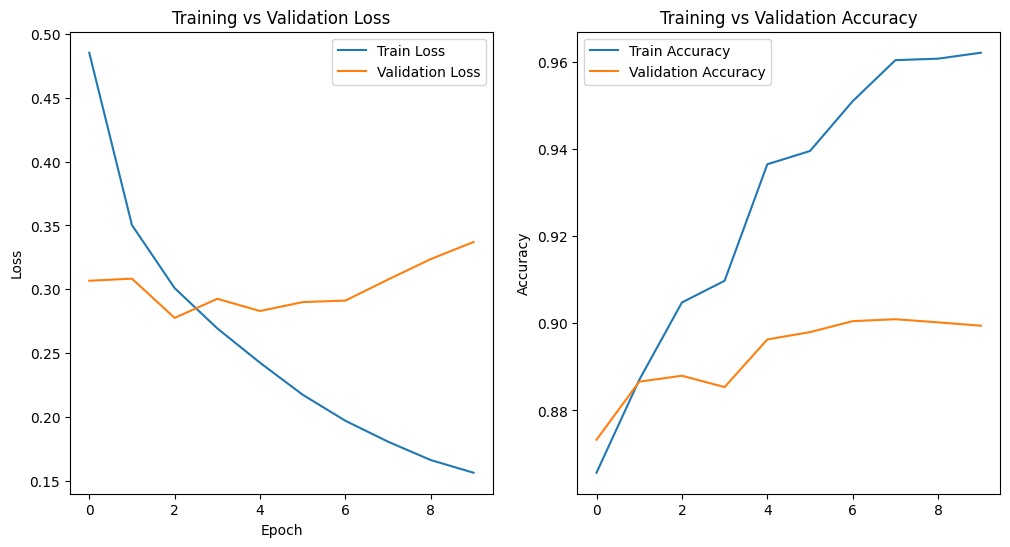

In [14]:
num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list = get_history("./BERT-IMDb-MoreData-0/checkpoint-12120/trainer_state.json")

epoch_list = [i for i in range(num_epochs_trained)]
_, ax = plt.subplots(nrows = 1, ncols=2, figsize=(12,6))
ax[0].plot(epoch_list, train_loss_list)
ax[0].plot(epoch_list, val_loss_list)
ax[0].legend(["Train Loss", "Validation Loss"])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training vs Validation Loss")

ax[1].plot(epoch_list, train_acc_list)
ax[1].plot(epoch_list, val_acc_list)
ax[1].legend(["Train Accuracy", "Validation Accuracy"])
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training vs Validation Accuracy")